In [44]:
import os
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [45]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-es")

c:\Users\david\miniconda3\envs\IAELPML\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [46]:
path_, filename_, category_, article_or_summary_,content_ = [],[],[],[],[]
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        path = os.path.join(dirname, filename).replace("\\","/")
        f = open(os.path.join(dirname, filename),"r")
        try:
            article = str(f.read())
            content_.append(article)
            path_.append(path)
            filename_.append(filename)
            category_.append(path.split("/")[-2])
            article_or_summary_.append(path.split("/")[-3])
        except:
            print("ERROR ABRIENDO EL FICHERO")
            print(filename)

        

In [47]:
df = pd.DataFrame({"path":path_, "filename":filename_, "category":category_, "article_or_summary":article_or_summary_,"content":content_}, columns=["path", "filename", "category", "article_or_summary","content"])
df

,path,filename,category,article_or_summary,content
0,data/News Articles/business/001.txt,001.txt,business,News Articles,Ad sales boost Time Warner profit\n\nQuarterly...
1,data/News Articles/business/002.txt,002.txt,business,News Articles,Dollar gains on Greenspan speech\n\nThe dollar...
2,data/News Articles/business/003.txt,003.txt,business,News Articles,Yukos unit buyer faces loan claim\n\nThe owner...
3,data/News Articles/business/004.txt,004.txt,business,News Articles,High fuel prices hit BA's profits\n\nBritish A...
4,data/News Articles/business/005.txt,005.txt,business,News Articles,Pernod takeover talk lifts Domecq\n\nShares in...
...,...,...,...,...,...
4443,data/Summaries/tech/397.txt,397.txt,tech,Summaries,BT is introducing two initiatives to help beat...
4444,data/Summaries/tech/398.txt,398.txt,tech,Summaries,A third of them read unsolicited junk e-mail a...
4445,data/Summaries/tech/399.txt,399.txt,tech,Summaries,This goes to the heart of the European project...
4446,data/Summaries/tech/400.txt,400.txt,tech,Summaries,Amit Yoran was director of the National Cyber ...


In [48]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [54]:
def text_cleaner(text):
    text = re.sub(r'\n\n', " . ", text)
    sentences = text.split(r' ')
    # Keep only the first sentence
    first_sentence = sentences[:10]
    # Perform cleaning operations on the first sentence
    cleaned_sentence = first_sentence.lower()
    cleaned_sentence = re.sub(r'\([^)]*\)', '', cleaned_sentence)
    cleaned_sentence = re.sub('"', '', cleaned_sentence)
    cleaned_sentence = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in cleaned_sentence.split(" ")])
    cleaned_sentence = re.sub(r"'s\b", "", cleaned_sentence)
    
    return [' '.join(chunk) for chunk in chunks]



In [55]:
data = df[df["article_or_summary"]=="News Articles"]
cleaned_text = []
for t in data['content']:
    cleaned_text.append(text_cleaner(t))

AttributeError: 'list' object has no attribute 'lower'

In [56]:
cleaned_text

[]

In [ ]:
translated_text = []
i=0
for text in cleaned_text:
    input_ids = tokenizer(text, return_tensors="pt").input_ids
    outputs = model.generate(input_ids=input_ids, num_beams=5, num_return_sequences=1)
    translated_text.append(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    print(i)
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
df_final = pd.DataFrame({"category":data["category"], "titular":cleaned_text,"traduccion":translated_text}, columns=["category", "titular","traduccion"])
df_final.to_csv('data/traducciones.csv')

NameError: name 'data' is not defined

In [72]:
df = pd.read_csv('traducciones.csv')
df = df[["category", "titular","traduccion"]]

In [73]:
df['traduccion'] = df['traduccion'].apply(lambda x: re.sub(r'[^a-zA-Záéíóú\s0-9$€£ñ]', '', x.lower())).astype(str)
df['titular'] = df['titular'].astype(str)

In [81]:
def split_into_three(words):
    # Calculate the size of each part
    part_size = len(words) // 3
    # Join the words in each part into strings
    first_part = ' '.join(words[:part_size])
    second_part = ' '.join(words[part_size:2*part_size])
    third_part = ' '.join(words[2*part_size:])
    return first_part,second_part,third_part

# Apply the function to the 'traduccion' column and create a list of dictionaries
new_rows = []

for index, row in df.iterrows():
    words_traduccion = re.findall(r'\w+', row['traduccion'])
    words_titular = re.findall(r'\w+', row['titular'])
    if len(words_traduccion) > 3 and len(words_titular) > 1:
        parts_traduccion = split_into_three(words_traduccion)
        parts_titular = split_into_three(words_titular)
        for part_traduccion, part_titular in zip(parts_traduccion, parts_titular):
            new_rows.append({'traduccion': part_traduccion, 'titular': part_titular})

# Create a DataFrame with 'traduccion' and 'titular' columns
df = pd.DataFrame(new_rows)
df

,traduccion,titular
0,beneficios trimestrales en nosotros medios gig...,quarterly profits at us media giant timewarner
1,76 a 1130 millones para los tres meses,jumped 76 to 1 13bn for the
2,a diciembre de 639 millones de años antes,three months to december from 639m year earlier
3,el dólar ha alcanzado su nivel más alto frente...,the dollar has hit its highest level against the
4,en casi tres meses después de que el jefe de la,euro in almost three months after the federal ...
...,...,...
6643,informáticas están seguras y ha renunciado des...,networks are safe and secure has
6644,de sólo un año en su puesto,resigned after only a year in his post
6645,los juegos de rol en,online role playing games
6646,línea consumen mucho tiempo pero,are time consuming but


### Tokenizer

In [82]:
# prepare english tokenizer
eng_tokenizer = Tokenizer() 
eng_tokenizer.fit_on_texts(list(df['titular']))

eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 10
print('Size of English Vocabulary : %d' % eng_vocab_size)

esp_tokenizer = Tokenizer() 
esp_tokenizer.fit_on_texts(list(df['traduccion']))

esp_vocab_size = len(esp_tokenizer.word_index) + 1
esp_length = 10
print('Size of Spanish Vocabulary : %d' % esp_vocab_size)

Size of English Vocabulary : 7066
Size of Spanish Vocabulary : 8210


In [83]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [84]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(df["titular"], df["traduccion"],
                                       test_size=0.1, random_state=0, shuffle=True) 

In [85]:
trainX = encode_sequences(eng_tokenizer, eng_length, x_tr)
trainY = encode_sequences(esp_tokenizer, esp_length, y_tr)

testX = encode_sequences(eng_tokenizer, eng_length, x_val)
testY = encode_sequences(esp_tokenizer, esp_length, y_val)

In [86]:
units = 256
model = Sequential()
model.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
model.add(LSTM(units))
model.add(RepeatVector(esp_length))
model.add(LSTM(units, return_sequences=True))
model.add(Dense(esp_vocab_size, activation='softmax'))
 
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

c:\Users\david\miniconda3\envs\IAELPML\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [87]:
filename = 'model.h1.Apr26v2.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=50, batch_size=256, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 8.8654
Epoch 1: val_loss improved from inf to 6.24991, saving model to model.h1.Apr26v2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 580ms/step - loss: 8.8397 - val_loss: 6.2499
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - loss: 6.1001
Epoch 2: val_loss improved from 6.24991 to 5.85097, saving model to model.h1.Apr26v2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - loss: 6.0961 - val_loss: 5.8510
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 5.8099
Epoch 3: val_loss improved from 5.85097 to 5.72478, saving model to model.h1.Apr26v2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 558ms/step - loss: 5.8091 - val_loss: 5.7248
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 5.6699
Epoch 4: val_loss improved from 5.72478 to 5.63663, saving model to model.h1.Apr26v2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 561ms/step - loss: 5.6705 - val_loss: 5.6366
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - loss: 5.6200
E

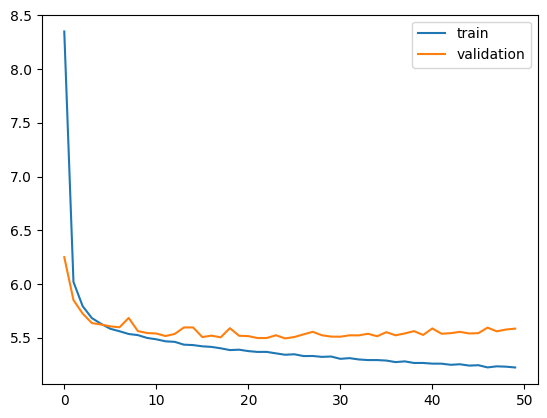

In [92]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [89]:
model = load_model(filename)
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds = np.argmax(preds,axis=1)
len(preds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


665

In [90]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [91]:
preds_text = []
for i in preds[:20]:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], esp_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], esp_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [95]:
pred_df = pd.DataFrame({'actual' : df["traduccion"][:20], 'predicted' : preds_text})

In [96]:
pred_df.head(20)

,actual,predicted
0,beneficios trimestrales en nosotros medios gig...,un en el el en la la a en el a a en l...
1,76 a 1130 millones para los tres meses,un en en el en la el la en la el el e...
2,a diciembre de 639 millones de años antes,un en en el en el la el la en la el el...
3,el dólar ha alcanzado su nivel más alto frente...,un en en el en el la el la en la el el...
4,en casi tres meses después de que el jefe de la,un en de la en de en el de la en la en el...
5,reserva federal dijo que el déficit comercial ...,un en el a en la la los en a a los en...
6,los propietarios de yukos gigantes rusos del p...,un en en el en la la a en el a a en l...
7,van a pedir al comprador de su antigua unidad,un en en el en la la a la el a a en l...
8,de producción que pague un préstamo de 900 mil...,un en el a en la la los en a a los en...
9,las vías aéreas británicas han culpado,un en el a en la la los en a a los en...
